In [16]:
import json
from pathlib import Path

import pandas as pd

questions = pd.read_csv(Path("qs.txt"))

data_dir = "eval_data"
jsonl_files = Path(data_dir).glob("*.jsonl")

records = []

for file in jsonl_files:
    with file.open("r") as f:
        # print(f"\ndoing file {file} ... ", end="")
        line: str
        for idx, line in enumerate(f):
            # print(idx, end=" ")
            line = line.strip()

            if len(line) == 0:
                continue

            # Parse JSON
            record = json.loads(line)

            annotator_name = record["metadata"].get("annotator_id", None)
            example_id = record.get("example_idx", None)
            llm_id = record.get("setup_id", None)

            flags = record.get("flags", [])
            flag_dict = {flag["label"]: flag["value"] for flag in flags}

            options = record.get("options", [])
            option_dict = {}
            for opt in options:
                option_label = opt.get("label", "")
                option_value = opt.get("value", "")
                option_dict[option_label] = option_value

            annotations = record.get("annotations", [])
            anns: dict[int, int] = {}
            for ann in annotations:
                ann_type = ann.get("type", None)

                if ann_type is None:
                    continue

                anns[ann_type] = anns.get(ann_type, 0) + 1

            row = {
                "annotator": annotator_name,
                "question_id": example_id,
                "llm": llm_id,

                "incorrect": anns.get(0, 0),
                "not_checkable": anns.get(1, 0),
                "misleading": anns.get(2, 0),
                "other": anns.get(3, 0),

                "accurate": flag_dict.get("The text 100% accurate and does not contain any errors.", None),
                "missing": flag_dict.get("The text is missing or incomplete.", None),
                "off_topic": flag_dict.get("The text is severely off-topic (seems completely unrelated to the data).",
                                           None),
                "clearness": option_dict.get("Answer Clearness (if it is understandable)", None),
                "length": option_dict.get(
                    "Answer length (if it was too short to be 100% clear or too long and made you lose time)", None),
                "usefulness": option_dict.get("Answer Usefulness", None),
                "like": option_dict.get("Do you like the answer? (Personal standpoint)", None),
            }

            records.append(row)

df = pd.DataFrame(records)
# df.set_index(["annotator", "question_id", "llm"], inplace=True)

df.head()

,annotator,question_id,llm,incorrect,not_checkable,misleading,other,accurate,missing,off_topic,clearness,length,usefulness,like
0,stefa20,1,gpt-o3-mini,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
1,stefa20,3,gemma2-9b,1,0,0,0,False,False,False,Mostly clear,Long enough,Neither useful nor useless,Yes
2,stefa20,6,gpt-4o,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
3,stefa20,8,deepseek-r1-8b,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
4,stefa20,7,deepseek-r1-8b,0,0,0,1,True,False,False,Completely clear,Long enough,Useful,Yes


In [17]:
# Define aggregation functions:
aggregations = {
    # For error counts, we sum over annotators.
    "incorrect": "sum",
    "not_checkable": "sum",
    "misleading": "sum",
    "other": "sum",
    # For flag-type responses (booleans), compute the mean (proportion of True)
    "accurate": "mean",
    "missing": "mean",
    "off_topic": "mean",
    # For categorical options, we compute the mode (most frequent value).
    "clearness": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "length": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "usefulness": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "like": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
}

# Group by question and LLM and apply the aggregations.
aggregated = df.groupby(["question_id", "llm"]).agg(aggregations).reset_index()

print("Aggregated metrics per question and LLM:")
aggregated

Aggregated metrics per question and LLM:


,question_id,llm,incorrect,not_checkable,misleading,other,accurate,missing,off_topic,clearness,length,usefulness,like
0,0,deepseek-r1-8b,3,0,7,0,0.3,0.0,0.0,Mostly clear,Long enough,Neither useful nor useless,No
1,0,gemma2-9b,0,0,0,1,0.9,0.1,0.0,Completely clear,Too short,Useful,No
2,0,gpt-4o,0,0,0,1,0.9,0.0,0.0,Completely clear,Long enough,Useful,Yes
3,0,gpt-o3-mini,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
4,0,llama3-1-8b,0,0,0,0,0.9,0.0,0.0,Completely clear,Too short,Useful,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,14,deepseek-r1-8b,0,0,0,1,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
71,14,gemma2-9b,0,0,0,2,0.9,0.0,0.0,Completely clear,Long enough,Useful,Yes
72,14,gpt-4o,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
73,14,gpt-o3-mini,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes


In [18]:
# --- 2. Distribution of categorical responses per LLM ---

# For example, you might want to see how the "clearness" ratings are distributed across LLMs.
llm_clearness_distribution = df.groupby("llm")["clearness"].value_counts().unstack(fill_value=0)
llm_length_distribution = df.groupby("llm")["length"].value_counts().unstack(fill_value=0)
llm_usefulness_distribution = df.groupby("llm")["usefulness"].value_counts().unstack(fill_value=0)
llm_like_distribution = df.groupby("llm")["like"].value_counts().unstack(fill_value=0)

In [19]:
print("\nClearness distribution per LLM:")
llm_clearness_distribution


Clearness distribution per LLM:


clearness,Completely clear,Mostly clear,Unclear
llm,,,
deepseek-r1-8b,104,45,1
gemma2-9b,84,42,24
gpt-4o,129,13,8
gpt-o3-mini,139,11,0
llama3-1-8b,95,29,26


In [20]:
print("\nLength distribution per LLM:")
llm_length_distribution


Length distribution per LLM:


length,Long enough,Too long,Too short
llm,,,
deepseek-r1-8b,107,37,6
gemma2-9b,74,0,76
gpt-4o,134,13,3
gpt-o3-mini,144,3,3
llama3-1-8b,117,13,20


In [21]:
print("\nUsefulness distribution per LLM:")
llm_usefulness_distribution


Usefulness distribution per LLM:


usefulness,Neither useful nor useless,Useful,Useless
llm,,,
deepseek-r1-8b,19,123,8
gemma2-9b,26,88,36
gpt-4o,7,135,8
gpt-o3-mini,3,147,0
llama3-1-8b,18,102,30


In [22]:
print("\nLike distribution per LLM:")
llm_like_distribution


Like distribution per LLM:


like,No,Yes
llm,,
deepseek-r1-8b,48,102
gemma2-9b,95,55
gpt-4o,20,130
gpt-o3-mini,7,143
llama3-1-8b,63,87


In [23]:
import pandas as pd
import numpy as np

def fleiss_kappa(ratings):
    """
    Compute Fleiss' Kappa for a matrix of shape (N, k),
    where N is number of items, and k is number of categories.
    `ratings[i, j]` = number of annotators who assigned item i to category j.
    """
    N, k = ratings.shape
    n_annotators = np.sum(ratings[0, :])  # total number of annotators per item (assuming each row sums to same value)

    # p_j: proportion of all assignments that were to category j
    p_j = np.sum(ratings, axis=0) / (N * n_annotators)

    # P_i: for each item i, what proportion of agreement there is among annotators
    #     = sum over categories of (count_j^2 - count_j) / (n_annotators * (n_annotators - 1))
    P_i = (np.sum(ratings * ratings, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))

    P_bar = np.mean(P_i)         # average P_i over all items
    P_e = np.sum(p_j * p_j)      # expected agreement if all labels are randomly distributed

    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa


# 1) Convert your annotation data into a "ratings matrix" for a single label
#    For example, let's do "clearness" with categories:
#        "Completely clear", "Mostly clear", "Unclear".
# df = pd.DataFrame([
#     {"item_id": "q1_llmA", "annotator": "ann1", "clearness": "Completely clear"},
#     {"item_id": "q1_llmA", "annotator": "ann2", "clearness": "Unclear"},
#     {"item_id": "q1_llmA", "annotator": "ann3", "clearness": "Mostly clear"},
#     # ... more data for other items
# ])

# 2) Determine the categories for clearness
clearness_categories = ["Completely clear", "Mostly clear", "Unclear"]

# 3) Pivot the DataFrame so we count how many times each item got each category
counts = (df
          .groupby(["question_id", "clearness"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=clearness_categories, fill_value=0)
          .reset_index(drop=True))  # remove item_id index if you want a raw matrix

ratings_matrix = counts.values  # N x k matrix

# 4) Compute Fleiss’ Kappa
fk = fleiss_kappa(ratings_matrix)
print("Fleiss’ Kappa for 'clearness':", fk)

Fleiss’ Kappa for 'clearness': 0.09598218342370929


In [24]:
df["usefulness"]

0                          Useful
1      Neither useful nor useless
2                          Useful
3                          Useful
4                          Useful
                  ...            
745                        Useful
746                        Useful
747                        Useful
748                        Useful
749                        Useful
Name: usefulness, Length: 750, dtype: object

In [25]:
import pandas as pd

def clearness_to_num(value):
    if value == "Completely clear":
        return 2
    elif value == "Mostly clear":
        return 1
    elif value == "Unclear":
        return 0
    return None

def usefulness_to_num(value):
    if value == "Useful":
        return 2
    elif value == "Neither useful nor useless":
        return 1
    elif value == "Useless":
        return 0
    return None

def like_to_num(value):
    return 1 if value == "Yes" else 0 if value == "No" else None

def accuracy_to_num(value):
    # If accurate == True -> 2, else -> 0
    # (Or some other weighting scheme)
    return 2 if value else 0

def length_to_num(value):
    if value == "Too long":
        return 2
    elif value == "Long enough":
        return 1
    elif value == "Too short":
        return 0
    return None

df["clearness_num"] = df["clearness"].apply(clearness_to_num)
df["usefulness_num"] = df["usefulness"].apply(usefulness_to_num)
df["like_num"] = df["like"].apply(like_to_num)
df["accuracy_num"] = df["accurate"].apply(accuracy_to_num)
df["length_num"] = df["length"].apply(length_to_num)

df["composite_score"] = (df["accuracy_num"]
                         + df["clearness_num"]
                         + df["usefulness_num"]
                         + df["like_num"])/7

# Average or sum per question-LLM
composite_agg = df.groupby(["question_id", "llm"])["composite_score"].mean().reset_index()
composite_agg

,question_id,llm,composite_score
0,0,deepseek-r1-8b,0.442857
1,0,gemma2-9b,0.742857
2,0,gpt-4o,0.928571
3,0,gpt-o3-mini,0.985714
4,0,llama3-1-8b,0.757143
...,...,...,...
70,14,deepseek-r1-8b,0.957143
71,14,gemma2-9b,0.942857
72,14,gpt-4o,1.000000
73,14,gpt-o3-mini,1.000000


In [26]:
# Average score for each model
composite_agg.groupby("llm")["composite_score"].mean()

llm
deepseek-r1-8b    0.790476
gemma2-9b         0.633333
gpt-4o            0.902857
gpt-o3-mini       0.976190
llama3-1-8b       0.706667
Name: composite_score, dtype: float64

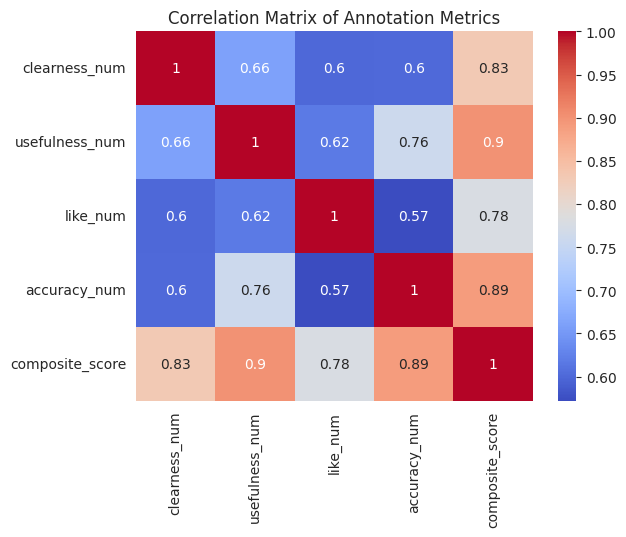

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose you have numeric columns: clearness_num, usefulness_num, like_num, accuracy_num
corr = df[['clearness_num', 'usefulness_num', 'like_num', 'accuracy_num', 'composite_score']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Annotation Metrics")
plt.show()


In [28]:
# Average composite score per annotator
annotator_stats = df.groupby("annotator")["composite_score"].agg(['mean', 'std', 'count']).reset_index()
annotator_stats


,annotator,mean,std,count
0,andry,0.748571,0.317516,25
1,angelop,0.857143,0.273551,25
2,dvd,0.782857,0.267643,25
3,elicaito,0.725714,0.377784,25
4,gattolfo,0.794286,0.327535,25
5,jacopo,0.754286,0.275162,25
6,polpiantina,0.868571,0.253948,25
7,sara,0.811429,0.278846,25
8,simov,0.725714,0.282482,25
9,ste,0.862857,0.271929,25


In [29]:
import statsmodels.formula.api as smf

# Example: Predicting composite_score with a random effect for annotators and question_id.
model = smf.mixedlm("composite_score ~ llm", data=df, groups=df["annotator"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: composite_score
No. Observations: 750     Method:             REML           
No. Groups:       30      Scale:              0.0821         
Min. group size:  25      Log-Likelihood:     -141.6002      
Max. group size:  25      Converged:          Yes            
Mean group size:  25.0                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.792    0.024 32.876 0.000  0.745  0.840
llm[T.gemma2-9b]   -0.159    0.033 -4.771 0.000 -0.224 -0.093
llm[T.gpt-4o]       0.110    0.033  3.308 0.001  0.045  0.175
llm[T.gpt-o3-mini]  0.181    0.034  5.360 0.000  0.115  0.247
llm[T.llama3-1-8b] -0.085    0.033 -2.560 0.010 -0.150 -0.020
Group Var           0.001    0.004                           



/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


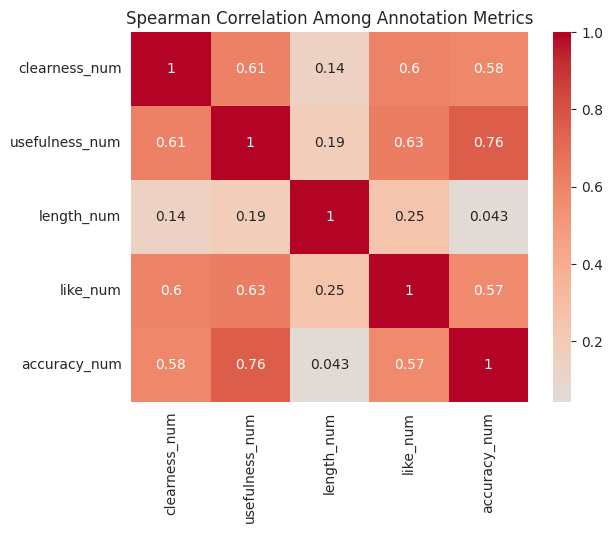

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose df has numeric columns for each metric, e.g.:
#   clearness_num, usefulness_num, length_num, like_num, accurate_num
# (already pre-mapped as discussed).

# Example correlation calculation (Spearman)
corr_matrix = df[["clearness_num", "usefulness_num", "length_num",
                  "like_num", "accuracy_num"]].corr(method="spearman")

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation Among Annotation Metrics")
plt.show()


In [36]:
import statsmodels.api as sm

# X = df[["clearness_num", "usefulness_num", "length_num", "accuracy_num"]]
# y = df["like_num"]

def likelihood(X, y):
    X = sm.add_constant(X)  # adds intercept
    logit_model = sm.Logit(y, X).fit()
    print(logit_model.summary())

likelihood(df[["clearness_num", "usefulness_num", "length_num", "accuracy_num"]], df["like_num"])

Optimization terminated successfully.
         Current function value: 0.348219
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               like_num   No. Observations:                  750
Model:                          Logit   Df Residuals:                      745
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Mar 2025   Pseudo R-squ.:                  0.4380
Time:                        18:40:48   Log-Likelihood:                -261.16
converged:                       True   LL-Null:                       -464.72
Covariance Type:            nonrobust   LLR p-value:                 8.049e-87
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.5950      0.608    -10.852      0.000      -7.786      -5.404
clearness_num    